In [1]:
#Import Utilities
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from scipy.stats import mode
from scipy.stats import multivariate_normal
from collections import defaultdict

In [2]:
def read_data(filename):
    dataset = []
    with open(filename) as f:
        temp = []
        currline = f.readline()
        while(currline):
            data = currline.strip().split(" ")
            if len(data) < 13 and temp:
                dataset.append(temp)
                temp = []
            elif len(data) >= 13:
                data = [float(i) for i in data]
                temp.append(data)
            currline = f.readline()
        if temp:
            dataset.append(temp)
    f.close()
    return dataset

In [3]:
train_dataset = read_data("Train_Arabic_Digit.txt")
test_dataset = read_data("Test_Arabic_Digit.txt")

     0   1   2   3   4   5   6   7   8   9  10  11  12
0  -85  -6  37  27  16   7   7   1   7   9  10   5   3
1   -1  94  19   9 -15 -11  -8 -13   4  -4  -7  -9  -3
2   37 -27  70  37 -23 -26  -6 -14   0  -1   2  -3  -6
3   34  12  16  22  61  45   5  23  25  23 -15   9   2
4    1   2  35 -59 -18  -3  46  36  21  18   4 -21  17
5    1   5 -29  54 -35 -10  20  65  -4   6   7   0   4
6    1  -2  -2  16 -24  56  54 -32 -25 -15 -13 -27 -20
7    7   2 -10   5 -33  28  -8 -32  12  48  39  24  47
8   11  13  11  -6  28 -13  33   4 -57 -19  46  39   9
9   -6   1  25 -20 -29  44 -46  33 -40 -11 -23  24   4
10  -1  -2  -1   4 -10   0  21  -8  39 -59 -29  43  41
11  -1  -3  -1  11  19 -11  -6  -3 -36  -1 -25 -49  71
12  -5  -1  -4  -2  -3 -27  25 -13 -24  50 -61  40  -7


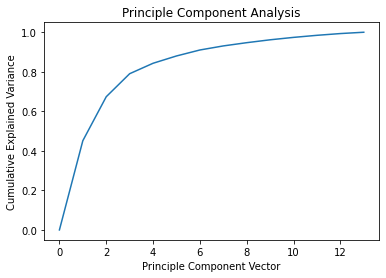

In [64]:
#Find Most important MFCCS
pooled = []
for utterance in train_dataset:
    for frame in utterance:
        pooled.append(frame)
pooled = np.array(pooled)

pca = PCA()
pca.fit(pooled)

x = [i for i in range(14)]
cumsum = 0
y = [0]
for explained_variance in pca.explained_variance_ratio_:
    cumsum += explained_variance
    y.append(cumsum)
plt.title("Principle Component Analysis")
plt.xlabel("Principle Component Vector")
plt.ylabel("Cumulative Explained Variance")
plt.plot(x,y)
plt.savefig("PCA", dpi=300)

print(pd.DataFrame(np.array(np.floor(pca.components_*100), dtype=np.int32)))

23344


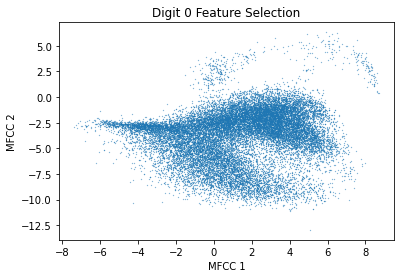

In [94]:
first_digit_len = 0
for count, utterance in enumerate(train_dataset):
    if count < 660:
        first_digit_len += len(utterance)
    else:
        break
print(first_digit_len)
first_digit = pooled[:23344, :2]
x = first_digit[:,0]
y = first_digit[:,1]
plt.scatter(x,y,s=0.05)
plt.title("Digit 0 Feature Selection")
plt.xlabel("MFCC 1")
plt.ylabel("MFCC 2")
plt.savefig("scatter1", dpi=300)
plt.show()

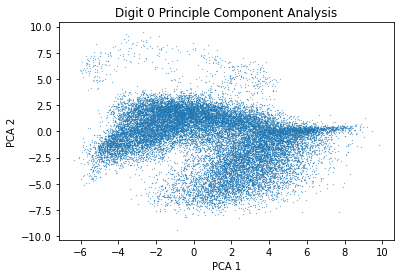

In [95]:
pooled_pca = pca.transform(pooled)
first_digit_pca = pooled_pca[:23344, :2]
x = first_digit_pca[:,0]
y = first_digit_pca[:,1]
plt.scatter(x,y,s=0.05)
plt.title("Digit 0 Principle Component Analysis")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.savefig("scatter2", dpi=300)
plt.show()

In [5]:
train_dataset_m = []
train_dataset_f = []
train_dataset_b = []

test_dataset_m = []
test_dataset_f = []
test_dataset_b = []


for i in range(10):
    curr_train = train_dataset[i*660:(i+1)*660]
    curr_test = test_dataset[i*220:(i+1)*220]
    
    train_dataset_m.append(curr_train[0:330])
    train_dataset_f.append(curr_train[330:660])
    train_dataset_b.append(curr_train)
    
    test_dataset_m.append(curr_test[0:110])
    test_dataset_f.append(curr_test[110:220])
    test_dataset_b.append(curr_test)

In [52]:
digit_1 = train_dataset_m[0][0]
digit_2 = train_dataset_m[1][0]
digit_3 = train_dataset_f[2][0]
digit_4 = train_dataset_f[3][0]
digit_5 = train_dataset_m[4][0]
digit_6 = train_dataset_m[5][0]
digit_7 = train_dataset_f[6][0]
digit_8 = train_dataset_f[7][0]
digit_9 = train_dataset_m[8][0]
digit_0 = train_dataset_m[9][0]

def digit_spectrum(data):
    heatmap = [[] for i in range(13)]
    for frame in data:
        for index, coef in enumerate(frame):
            heatmap[index].append(coef)
    heatmap = np.array(heatmap)
    return heatmap

heatmap_1 = digit_spectrum(digit_1)
heatmap_2 = digit_spectrum(digit_2)
heatmap_3 = digit_spectrum(digit_3)
heatmap_4 = digit_spectrum(digit_4)       
heatmap_5 = digit_spectrum(digit_5)
heatmap_6 = digit_spectrum(digit_6)
heatmap_7 = digit_spectrum(digit_7)
heatmap_8 = digit_spectrum(digit_8)       
heatmap_9 = digit_spectrum(digit_9)
heatmap_0 = digit_spectrum(digit_0)      

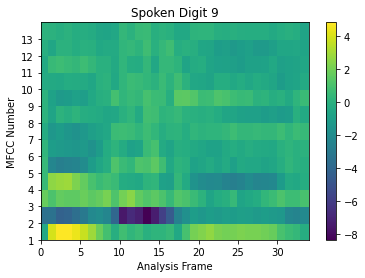

In [61]:
colorbar = plt.pcolor(heatmap_0)
plt.colorbar(colorbar)
plt.title("Spoken Digit 9")
plt.xlabel("Analysis Frame")
plt.ylabel("MFCC Number")
plt.yticks([i for i in range(13)], [str(i+1) for i in range(13)])
plt.savefig("Diff Digit", dpi=300)
plt.show()

In [96]:
#Create KMeans Heatmap
def kmeans_heatmap(data, feature_subset_num):
    
    inertias = []
    normalized = []
    
    for dataset in data:
        
        phonemes = []
        for spoken_data in dataset:
            for phoneme in spoken_data:
                phonemes.append(phoneme)
        phonemes = np.array(phonemes)
        phoneme_subset = phonemes[:,:feature_subset_num]
        
        inertia = []
        for i in range(1,10):
            kmeans = KMeans(n_clusters=i)
            kmeans.fit(phoneme_subset)
            inertia.append(kmeans.inertia_)
        inertia = np.array(inertia)
        inertias.append(inertia)        
        
        normalized_inertia = inertia/max(inertia)
        normalized.append(normalized_inertia)
    
    inertias = np.array(inertias)
    normalized = np.array(normalized)
    return inertias, normalized

In [97]:
elbow_f, heatmap_f = kmeans_heatmap(test_dataset_f, 5)
elbow_m, heatmap_m = kmeans_heatmap(test_dataset_m, 5)

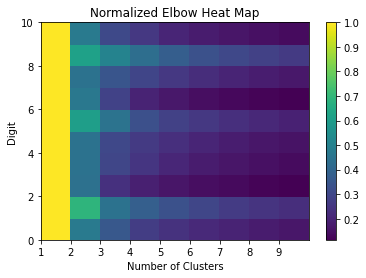

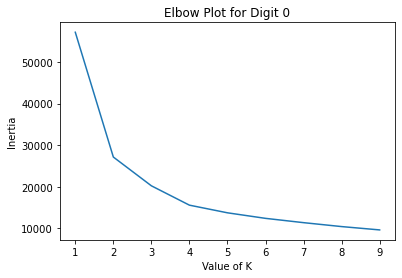

In [105]:
colorbar = plt.pcolor(heatmap_f)
plt.colorbar(colorbar)
plt.title("Normalized Elbow Heat Map")
plt.xlabel("Number of Clusters")
plt.ylabel("Digit")
plt.xticks([i for i in range(9)], [str(i+1) for i in range(9)])
plt.savefig("Elbow Heatmap", dpi=300)
plt.show()

x= [i+1 for i in range(9)]
y= elbow_f[0]
plt.plot(x,y)
plt.title("Elbow Plot for Digit 0")
plt.xlabel("Value of K")
plt.ylabel("Inertia")
plt.savefig("Elbow", dpi=300)
plt.show()
#plt.imshow(heatmap_m)

In [157]:
def kmeans_mixture(data, feature_subset_num, cluster_num):
    #data is a partitioned dataset of digits
    #feature_subset_num is the number of features to consider
    #cluster_num is the number of clusters
    
    #predictors = []
    means = []
    covs = []
    pis = []
    kmeans_arr = []
    mixtures = []
    
    for dataset in data:
        
        phonemes = []
        for spoken_data in dataset:
            for phoneme in spoken_data:
                phonemes.append(phoneme)
        phonemes = np.array(phonemes)
        phoneme_subset = phonemes[:,:feature_subset_num]
    
        kmeans = KMeans(n_clusters = cluster_num)
        kmeans.fit(phoneme_subset)
        clusters = defaultdict(list)
        for i in range(len(phoneme_subset)):
            clusters[kmeans.labels_[i]].append(phoneme_subset[i])
        digit_mean = []
        digit_cov = []
        digit_pi = []
        mixture = []
        for key, cluster in clusters.items():
            model = GaussianMixture()
            model.fit(cluster)
            digit_mean.append(model.means_[0])
            digit_cov.append(model.covariances_[0])
            digit_pi.append(len(cluster)/len(phoneme_subset))
            mixture.append(model)
            
        means.append(digit_mean)
        covs.append(digit_cov)
        pis.append(digit_pi)
        kmeans_arr.append(kmeans)
        mixtures.append(mixture)
        
    
    return np.array(means), np.array(covs), np.array(pis) , kmeans_arr, mixtures  

In [158]:
#predictor_m = kmeans_mixture(train_dataset_m, 5, 4)
#predictor_f = kmeans_mixture(train_dataset_f, 5, 4)
predictor_b = kmeans_mixture(train_dataset_b, 5, 5)

<ipython-input-159-6d32a276c8fa>:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot()


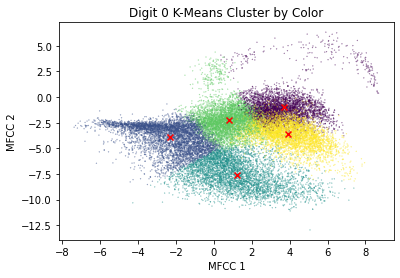

In [159]:
first_digit = pooled[:23344, :5]
first_kmeans = predictor_b[3][0]
first_mixtures = predictor_b[4][0]

labels = first_kmeans.predict(first_digit)
plt.scatter(first_digit[:, 0], first_digit[:,1], s=0.05, c=labels)
plt.xlabel("MFCC 1")
plt.ylabel("MFCC 2")
plt.title("Digit 0 K-Means Cluster by Color")
ax = plt.subplot()
for mixture in first_mixtures:
    plt.scatter(mixture.means_[0][0], mixture.means_[0][1],  marker='x', c='r')
plt.show()
#plt.savefig("KMeans Cluster")
    
    

In [141]:
def gaussian_heatmap(data, feature_subset_num):
    
    aics = []
    bics = []
    normalized_aics = []
    normalized_bics = []
    
    for dataset in data:
        
        phonemes = []
        for spoken_data in dataset:
            for phoneme in spoken_data:
                phonemes.append(phoneme)
        phonemes = np.array(phonemes)
        phoneme_subset = phonemes[:,:feature_subset_num]
        
        aic = []
        bic = []
        for i in range(1,10):
            gmm = GaussianMixture(n_components=i)
            gmm.fit(phoneme_subset)
            aic.append(gmm.aic(phoneme_subset))
            bic.append(gmm.bic(phoneme_subset))
        
        aic = np.array(aic)
        bic = np.array(bic)
        
        normalized_aic = aic/np.max(aic)
        normalized_bic = bic/np.max(bic)
        
        aics.append(aic)
        bics.append(bic)
        normalized_aics.append(normalized_aic)
        normalized_bics.append(normalized_bic)
    
    aics = np.array(aics)
    bics = np.array(bics)
    normalized_aics = np.array(normalized_aics)
    normalized_bics = np.array(normalized_bics)
    
    return aics, bics, normalized_aics, normalized_bics

In [142]:
aics_f, bics_f, normalized_aics_f, normalized_bics_f = gaussian_heatmap(test_dataset_f, 5)
aics_m, bics_m, normalized_aics_m, normalized_bics_m = gaussian_heatmap(test_dataset_m, 5)

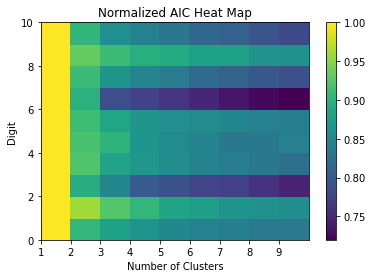

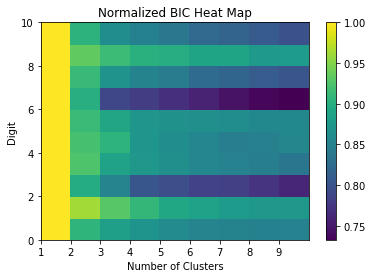

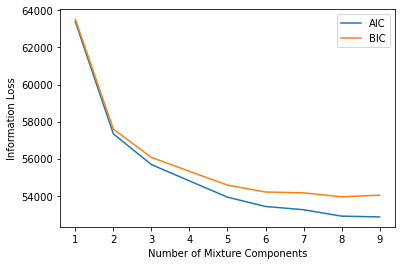

In [150]:
colorbar = plt.pcolor(normalized_aics_m)
plt.colorbar(colorbar)
plt.title("Normalized AIC Heat Map")
plt.xlabel("Number of Clusters")
plt.ylabel("Digit")
plt.xticks([i for i in range(9)], [str(i+1) for i in range(9)])
plt.savefig("AIC Heatmap", dpi=300)
plt.show()

colorbar = plt.pcolor(normalized_bics_m)
plt.colorbar(colorbar)
plt.title("Normalized BIC Heat Map")
plt.xlabel("Number of Clusters")
plt.ylabel("Digit")
plt.xticks([i for i in range(9)], [str(i+1) for i in range(9)])
plt.savefig("BIC Heatmap", dpi=300)
plt.show()

x= [i+1 for i in range(9)]
y1 = aics_m[0]
y2 = bics_m[0]

plt.plot(x, y1, label = "AIC")
plt.plot(x, y2, label = "BIC")
plt.xlabel("Number of Mixture Components")
plt.ylabel("Information Loss")
plt.savefig("AIC,BIC", dpi=300)
plt.legend()
plt.show()

In [154]:
def gaussian_mixture(data, feature_subset_num, cluster_num):
    #data is a partitioned dataset of digits
    #feature_subset_num is the number of features to consider
    #cluster_num is the number of clusters
    
    #predictors = []
    means = []
    covs = []
    pis = []
    models = []
    
    for dataset in data:
        
        phonemes = []
        for spoken_data in dataset:
            for phoneme in spoken_data:
                phonemes.append(phoneme)
        phonemes = np.array(phonemes)
        phoneme_subset = phonemes[:,:feature_subset_num]
    
        model = GaussianMixture(n_components = cluster_num)
        model.fit(phoneme_subset)
        
        means.append(model.means_)
        covs.append(model.covariances_)
        pis.append(model.weights_)
        models.append(model)
        #predictors.append(model)
    
    return np.array(means),np.array(covs),np.array(pis),models   

In [155]:
#predictor_m_2 = gaussian_mixture(train_dataset_m, 5, 4)
#predictor_f_2 = gaussian_mixture(train_dataset_f, 5, 4)
predictor_b_2 = gaussian_mixture(train_dataset_b, 5, 5)

[[ 1.32857558 -2.11698555  0.1513068  -1.30080922 -0.85947357]
 [-2.79418634 -2.82193343  0.47662766 -0.03818751  0.10791796]
 [ 3.93794709 -3.47538563 -2.15471324 -2.79933949 -1.48009661]
 [ 0.07252158 -6.25153801  0.81483686 -0.52222719  0.52844483]
 [ 3.3623273  -1.57823231 -0.30483599 -0.86135278 -1.18538066]]


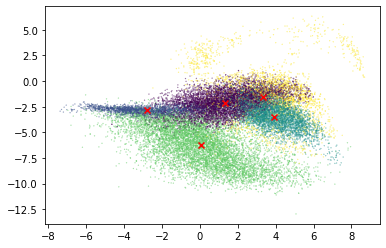

In [172]:
first_digit = pooled[:23344, :5]
model = predictor_b_2[3][0]
labels = model.predict(first_digit)
plt.scatter(first_digit[:, 0], first_digit[:,1], s=0.05, c=labels)
print(model.means_)
for component in model.means_:
    plt.scatter(component[0], component[1],  marker='x', c='r')
plt.savefig("GMM model comp", dpi=300)
plt.show()

In [208]:
def get_accuracy(test_dataset, predictor, feature_subset_num, cluster_num):
    correct = 0
    total = 0
    digits = len(test_dataset)
    confusion_matrix = np.zeros((10,10))
    for count, dataset in enumerate(test_dataset):
        for spoken_data in dataset:
            spoken_data_array = np.array(spoken_data)
            spoken_data_subset = spoken_data_array[:,:feature_subset_num]
            identity = -1
            max_prob = -1
            for i in range(digits):
                cluster_means = predictor[0][i]
                cluster_covs = predictor[1][i]
                cluster_weights = predictor[2][i]
                prob_sum = None
                for j in range(cluster_num):
                    gaussian = multivariate_normal(cluster_means[j], cluster_covs[j])
                    prob = gaussian.pdf(spoken_data_subset)
                    prob = cluster_weights[j]*prob
                    if not isinstance(prob_sum, np.ndarray):
                        prob_sum = prob
                    else:
                        prob_sum += prob
                prod = np.cumprod(prob_sum)[-1]
                if prod > max_prob:
                    max_prob = prod
                    identity = i
            confusion_matrix[identity][count] += 1
            if identity == count:
                correct += 1
            total += 1
    return correct, total, confusion_matrix           

In [170]:
kmeans_accuracy = get_accuracy(test_dataset_b, predictor_b, 5, 5)
guassian_accuracy = get_accuracy(test_dataset_b, predictor_b_2, 5, 5)

In [171]:
print(kmeans_accuracy)
print(guassian_accuracy)

(1677, 2200, array([[168.,   2.,   2.,   4.,   2.,   5.,   3.,   8.,   1.,  10.],
       [  0., 207.,   1.,   0.,   3.,   0.,   0.,   8.,   1.,   0.],
       [  0.,   3., 133.,  18.,   0.,   0.,   0.,   0.,  21.,   1.],
       [  7.,   0.,  38., 140.,   5.,   0.,   0.,   0.,   9.,   1.],
       [  0.,   0.,   0.,   5., 166.,   4.,   0.,  51.,   0.,   0.],
       [  0.,   1.,   8.,   2.,   0., 182.,   2.,   9.,   3.,   4.],
       [ 20.,   2.,  29.,   3.,   0.,   8., 213.,   5.,  10.,  14.],
       [ 19.,   5.,   2.,  45.,  40.,   4.,   1., 128.,   0.,  15.],
       [  0.,   0.,   0.,   1.,   0.,   0.,   0.,   0., 165.,   0.],
       [  6.,   0.,   7.,   2.,   4.,  17.,   1.,  11.,  10., 175.]]))
(1709, 2200, array([[177.,   1.,   2.,   3.,   5.,   4.,   8.,   4.,   0.,  10.],
       [  0., 203.,   3.,   0.,   7.,   0.,   0.,   3.,   7.,   0.],
       [  0.,   1., 152.,  19.,   0.,   0.,   0.,   1.,  22.,   1.],
       [  5.,   2.,  17., 141.,   1.,   1.,   0.,   0.,   2.,   1.],
      

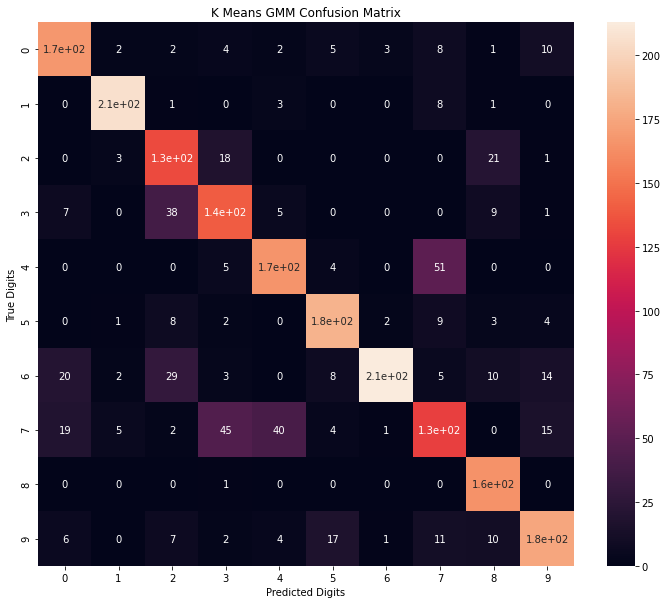

In [189]:
import seaborn as sn
df_cm = pd.DataFrame(np.array(kmeans_accuracy[2],dtype=np.int32), index = [i for i in range(10)],
                  columns = [i for i in range(10)])
plt.figure(figsize = (12,10))
plt.xlabel("Predicted Digits")
plt.ylabel("True Digits")
plt.title("K Means GMM Confusion Matrix")
ax = sn.heatmap(df_cm, annot=True)
ax.set(xlabel='Predicted Digits', ylabel='True Digits')
plt.savefig("Kmeans")

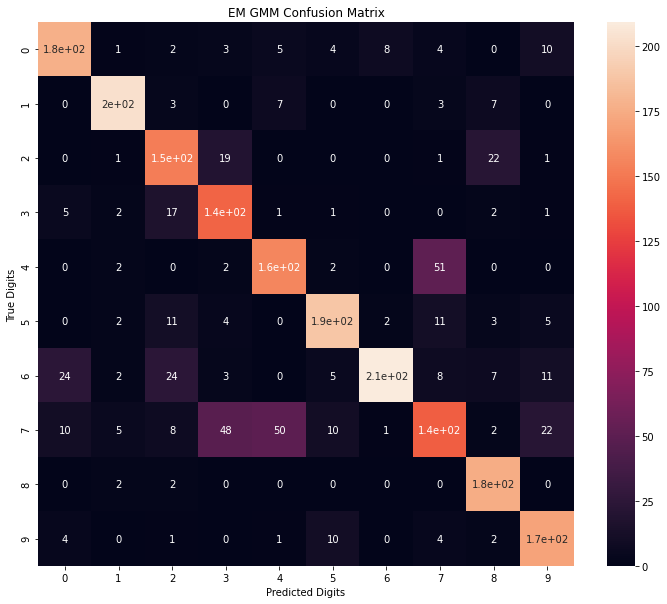

In [191]:
df_cm = pd.DataFrame(np.array(guassian_accuracy[2],dtype=np.int32), index = [i for i in range(10)],
                  columns = [i for i in range(10)])
plt.figure(figsize = (12,10))
plt.xlabel("Predicted Digits")
plt.ylabel("True Digits")
plt.title("EM GMM Confusion Matrix")
ax = sn.heatmap(df_cm, annot=True)
ax.set(xlabel='Predicted Digits', ylabel='True Digits')
plt.savefig("EM")

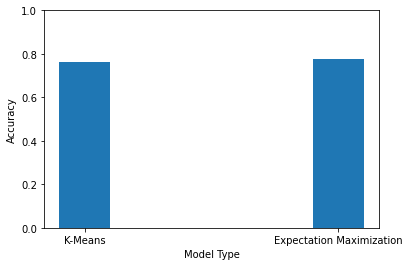

In [206]:
accuracy = [1677/2200, 1709/2200]
names = ["K-Means", "Expectation Maximization"]
plt.ylim([0,1])
plt.bar(names, accuracy, width=0.2)
plt.xlabel("Model Type")
plt.ylabel("Accuracy")
plt.savefig("Bar")

In [ ]:
data = []
for i in range(1, 14):
    predictor_2 = gaussian_mixture(train_dataset_b, i, 5)
    predictor_1 = kmeans_mixture(train_dataset_b, i, 5)
    true_1, _, _ = get_accuracy(test_dataset_b, predictor_1, i, 5)
    true_2, _, _ = get_accuracy(test_dataset_b, predictor_2, i, 5)
    data.append((true_1,true_2))